# Try out the Gaia (E)DR3 zero-point correction code

Example data was obtained with the following query

```
select * from gaiaedr3.gaia_source
where phot_g_mean_mag between 17.9 and 18.1
and random_index between 700000000 and 701000000
```

This results in 21594 sources with a mix of 2-p, 5-p, and 6-p astrometric solutions.

In [1]:
import numpy as np
from astropy.table import Table

from zero_point import zpt
zpt.load_tables()

## Read the data

In [2]:
data = Table.read('ZPrandomG18.fits',format='fits')

gmag = data['phot_g_mean_mag']
nueffused = data['nu_eff_used_in_astrometry']
psc = data['pseudocolour']
sinbeta = np.sin(np.deg2rad(data['ecl_lat']))
soltype = data['astrometric_params_solved']

## Blindly use the get_zpt function

Using the `get_zpt()` function blindly will fail if there are source with 2-p solutions in the input list. Thus the line of code below will lead to a runtime error.

In [3]:
zpvals = zpt.get_zpt(gmag, nueffused, psc, sinbeta, soltype)

ValueError: Some of the sources have an invalid number of the astrometric_params_solved and are not one of the 
            possible values (31,95). Please provide an acceptable value.

## Remove the 2-p solutions

Re-running the line of above with the 2-p solution removed works. The code automatically deals with a mix of 5-p and 6-p solutions. However, note the warning.

In [4]:
valid = soltype>3
zpvals = zpt.get_zpt(gmag[valid], nueffused[valid], psc[valid], sinbeta[valid], soltype[valid])

/home/brown/.local/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:227: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


As explained in Lindegren et al. 2020, the interpolations are only calibrated within the following intervals:

1. $G$ magnitude: 
    6 < phot_g_mean_mag < 21
2. Colour:
    1. 1.1 < nu_eff_used_in_astrometry < 1.9 (5-p sources)
    2. 1.24 < pseudocolour < 1.72 (6-p sources)
        
Outside these ranges, the zero-point obtained is an **extrapolation**.

### Try turning off the warnings

This makes the code return NaN for the sources that fall outside the recomended limits, instead of an extrapolated zero point

In [5]:
valid = soltype>3
zpvals = zpt.get_zpt(gmag[valid], nueffused[valid], psc[valid], 
                     sinbeta[valid], soltype[valid],_warnings=False)

## Try scalars as input

The code should also work for a single source. This is tested in the next code block.

In [6]:
#separate 5p and 6p sources
fivep = (soltype==31)
sixp = (soltype==95)

In [7]:
#query the zero-point for individual stars
zpvals5p = zpt.get_zpt(gmag[fivep][0], nueffused[fivep][0], psc[fivep][0], sinbeta[fivep][0], soltype[fivep][0])
print(zpvals5p)
zpvals6p = zpt.get_zpt(gmag[sixp][0], nueffused[sixp][0], psc[sixp][0], sinbeta[sixp][0], soltype[sixp][0])
print(zpvals6p)

-0.026325
-0.022906


## Mix of input variable lengths

*This should fail.*

In [8]:
zpvals5p = zpt.get_zpt(gmag[fivep][0], nueffused[fivep][0:2], psc[fivep][0], sinbeta[fivep][0], soltype[fivep][0])
print(zpvals5p)

ValueError: Dimension mismatch! At least one of the inputs has a different shape than the rest.

## Using the Pandas wrapper

If you have pandas installed and work with DataFrames, you can use the wrapper provided with the package.

**NOTE**: This way of computing the zero point is slower than using the *get_zpt()* function. Also, it returns NaN outside interpolation limits.

In [9]:
import pandas as pd

In [10]:
data = Table.read('ZPrandomG18.fits',format='fits').to_pandas().query('astrometric_params_solved>3')

/home/brown/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/brown/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/brown/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'phot_rp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/brown/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'phot_rp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
data.head()

solution_id                       designation            source_id  \
0  1636042515805110273  b'Gaia EDR3 4128184889773240576'  4128184889773240576   
1  1636042515805110273  b'Gaia EDR3 4282960152307229056'  4282960152307229056   
2  1636042515805110273  b'Gaia EDR3 277400770735535872 '   277400770735535872   
3  1636042515805110273  b'Gaia EDR3 276968254652665088 '   276968254652665088   
4  1636042515805110273  b'Gaia EDR3 278686271627726208 '   278686271627726208   

   random_index  ref_epoch          ra  ra_error        dec  dec_error  \
0     700672459     2016.0  257.064292  0.139806 -20.302579   0.092557   
1     700995172     2016.0  278.775972  0.113399   2.783653   0.127178   
2     700636589     2016.0   68.741200  0.102306  56.133606   0.074401   
3     700545854     2016.0   65.202580  0.091627  57.207378   0.058449   
4     700960036     2016.0   69.697497  0.102841  57.926972   0.078073   

   parallax  ...  bp_ssc_error1  bp_ssc_error2  bp_ssc_error3  rp_ssc_error0  \
0  0.459703  ...       0.001569       0.001572       0.002366       0.002254   
1  1.303258  ...            NaN            NaN            NaN            NaN   
2  0.620932  ...       0.001046       0.001156       0.001922       0.001610   
3  0.442455  ...       0.000749       0.000807       0.001292       0.001130   
4  0.294754  ...       0.001117       0.001197       0.001927       0.001611   

   rp_ssc_error1  rp_ssc_error2  rp_ssc_error3    nu_eff  nu_eff_error  \
0       0.001976       0.002073       0.002301  1.501606      0.220587   
1            NaN            NaN            NaN       NaN           NaN   
2       0.001608       0.001783       0.002006  1.389044      0.165566   
3       0.001100       0.001198       0.001320  1.424694      0.113924   
4       0.001565       0.001707       0.001874  1.425679      0.165529   

   phot_robust_bp_rp_excess_factor  
0                         1.599339  
1                         1.383148  
2                         1.283804  
3                         1.276085  
4                         1.279839  

[5 rows x 168 columns]

In [12]:
data['zpt'] = data.apply(zpt.zpt_wrapper,axis=1)

In [13]:
data.zpt

0       -0.022906
1       -0.044078
2       -0.026325
3       -0.026225
4       -0.025398
           ...   
21589         NaN
21590   -0.025771
21591   -0.027741
21592   -0.025131
21593   -0.026416
Name: zpt, Length: 21283, dtype: float64

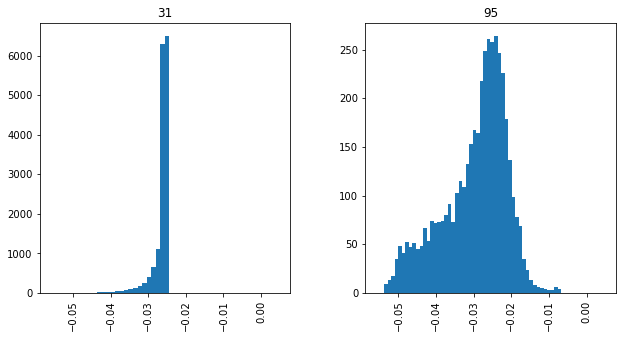

In [14]:
data.hist(column='zpt',by='astrometric_params_solved',figsize=(10,5),sharex=True,bins=50);

## Reproducing Figures 20 and 21 of Lindegren et al. 2020

In [15]:
import scipy.stats
import matplotlib.pyplot as plt

In [16]:
# define array in the space of G vs colour (nu_eff or pseudocolour)
g_vector = np.linspace(6,21,100)
c_vector = np.linspace(1.1,1.9,100)

G,C = np.meshgrid(g_vector,c_vector)

beta_90 = np.vstack((G.flat,C.flat,-90*np.ones_like(G.flat))).T
beta0 = np.vstack((G.flat,C.flat,0*np.ones_like(G.flat))).T
beta90 = np.vstack((G.flat,C.flat,90*np.ones_like(G.flat))).T

### Figure 20

In [17]:
z5_beta_90 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         -90*np.ones_like(G.flat),31*np.ones_like(G.flat))
z5_beta0 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         0*np.ones_like(G.flat),31*np.ones_like(G.flat))
z5_beta90 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         90*np.ones_like(G.flat),31*np.ones_like(G.flat))

/home/brown/.local/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:199: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  UserWarning)
/home/brown/.local/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:214: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
                mag). Outside this range, the zero-point calculated can be seriously wrong.
  UserWarning)


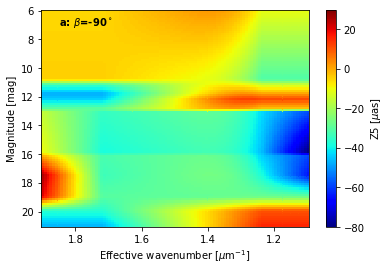

In [18]:
plt.pcolormesh(C,G,1000*z5_beta_90.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z5 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'a: $\beta$=-90$^\circ$',xy=(1.85,7),fontweight='bold');

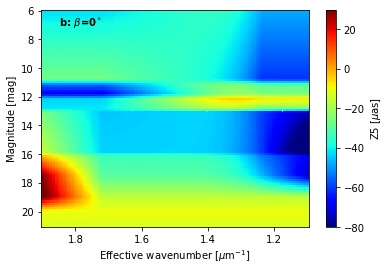

In [19]:
plt.pcolormesh(C,G,1000*z5_beta0.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z5 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'b: $\beta$=0$^\circ$',xy=(1.85,7),fontweight='bold');

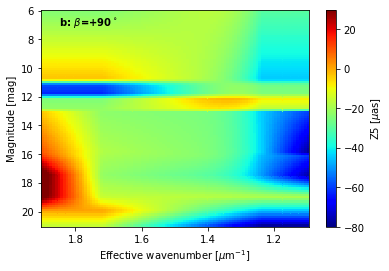

In [20]:
plt.pcolormesh(C,G,1000*z5_beta90.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z5 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'b: $\beta$=+90$^\circ$',xy=(1.85,7),fontweight='bold');

### Figure 21

In [21]:
z6_beta_90 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         -90*np.ones_like(G.flat),95*np.ones_like(G.flat))
z6_beta0 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         0*np.ones_like(G.flat),95*np.ones_like(G.flat))
z6_beta90 = zpt.get_zpt(G.flatten(),C.flatten(),C.flatten(),
                         90*np.ones_like(G.flat),95*np.ones_like(G.flat))

/home/brown/.local/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:227: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


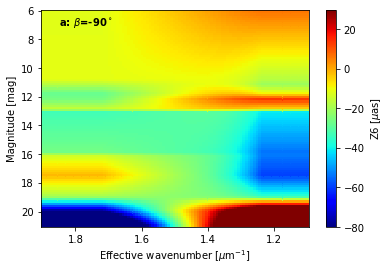

In [22]:
plt.pcolormesh(C,G,1000*z6_beta_90.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z6 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'a: $\beta$=-90$^\circ$',xy=(1.85,7),fontweight='bold');

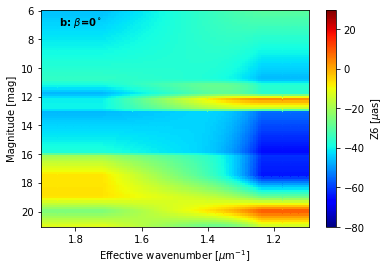

In [23]:
plt.pcolormesh(C,G,1000*z6_beta0.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z6 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'b: $\beta$=0$^\circ$',xy=(1.85,7),fontweight='bold');

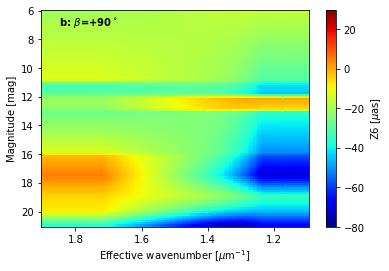

In [24]:
plt.pcolormesh(C,G,1000*z6_beta90.reshape(G.shape),shading='nearest',
           cmap='jet',vmin=-80, vmax=30)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar=plt.colorbar();
cbar.set_label(r'Z6 [$\mu$as]')
plt.xlabel(r'Effective wavenumber [$\mu$m$^{-1}$]');
plt.ylabel(r'Magnitude [mag]');
plt.annotate(r'b: $\beta$=+90$^\circ$',xy=(1.85,7),fontweight='bold');